# USING SELINIUM AND BEAUTIFULSOUP TO WEBSCRAPE FOR MODEL DEVELOPMENT AND DEPLOYMENT

In [8]:
# Importing the needed libaries 
import requests
from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.select import Select
import time
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

## STEP 1: USING  SELINIUM TO NAVIGATE  TO THE EXTRACTION WEBSITE

chromedriver_path =r"C:\Users\HP\Desktop\chromedriver.exe"

chrome_options = Options()
chrome_service = Service(chromedriver_path)

driver = webdriver.Chrome(service=chrome_service, options=chrome_options)

driver.get('https://nigeriapropertycentre.com/')

#driver.maximize_window()
#time.sleep(5)

# selecting for rent
rent = driver.find_element(By.ID, 'li-cid-for-rent')
rent.click()

# Filtering for Lagos
lagos= driver.find_element(By.CLASS_NAME, 'form-control')
lagos.send_keys('Lekki, Lagos')

#Filtering for houses 
house = driver.find_element (By.TAG_NAME, 'select')
dropdown = Select(house)
dropdown.select_by_visible_text('House')
time.sleep(2)

# clicking on search 
search = driver.find_element(By.XPATH, '//button[@class ="btn btn-lg btn-base btn-block"]')
search.click()

current_url = driver.current_url


######################


current_url

## STEP 2: PARSING URL TO BEAUTIFULSOUP FOR DATA EXTRACTION

listings = []
url = current_url

for i in range(1, 229):
    url = f"{url}showtype?page={i}"
    response = requests.get(url)

    res = response.content
    soup = BeautifulSoup(res, 'html.parser')


    #Extracting all houses for rent on current page
    cards = soup.find_all('div', {'wp-block property list'})

    #Data to extract: DESCRIPTION, LOCATION, PRICE, BEDROOMS, TOILET, BATHROOMS, PARKING SPACE

    #Extracting a house description on current page
    cards[0].find('h4').get_text()

    #Extracting a house location on current page
    cards[0].find('address').get_text().strip()

    #Extracting a house price on current page
    cards[0].find('span', {'class': 'pull-sm-left'}).get_text().replace('per annum', "").strip().replace('₦', "").replace(',', "")

    #Extracting other information a the house ( the other house information consist of the bedrooms, bathrooms, toilets and parking space which will be separated later)
    cards[0].find('div', {'class': 'wp-block-footer'}).find('ul').get_text().replace(' Save', "")
    
    # Extracting all houses for rent on current page
    for result in cards:
        description = result.find('h4').get_text()
        location = result.find('address').get_text().strip()
        price = result.find('span', {'class': 'pull-sm-left'}).get_text().replace('per annum', "").strip().replace('₦', "").replace(',', "")
        others = result.find('div', {'class': 'wp-block-footer'}).find('ul').get_text().replace(' Save', "")
        
        listings.append([description, others, location, price])
        print(i)

In [21]:
listings

[['3 bedroom terraced duplex for rent',
  '3 Bedrooms3 Bathrooms4 Toilets2 Parking Spaces',
  'Orchid, Lekki, Lagos',
  '4700000'],
 ['3 bedroom terraced duplex for rent',
  '3 Bedrooms3 Bathrooms4 Toilets2 Parking Spaces',
  'Osapa, Lekki, Lagos',
  '4000000'],
 ['5 bedroom detached duplex for rent',
  '5 Bedrooms5 Bathrooms5 Toilets4 Parking Spaces',
  'Chevron, Lekki, Lagos',
  '7000000'],
 ['4 bedroom terraced duplex for rent',
  '4 Bedrooms4 Bathrooms5 Toilets3 Parking Spaces',
  'Ikota Gra, Ikota, Lekki, Lagos',
  '4000000'],
 ['4 bedroom semi-detached duplex for rent',
  '4 Bedrooms4 Bathrooms4 Toilets',
  'Lekki, Lagos',
  '4500000'],
 ['4 bedroom terraced duplex for rent',
  '4 Bedrooms4 Bathrooms4 Toilets',
  'Lekki, Lagos',
  '4500000'],
 ['4 bedroom semi-detached duplex for rent',
  '4 Bedrooms4 Bathrooms4 Toilets',
  'Orchid, Lekki, Lagos',
  '3000000'],
 ['1 bedroom house for rent',
  '1 Bedroom1 Bathroom2 Toilets',
  'Ikate, Ikate, Lekki, Lagos',
  '8000000'],
 ['3 bedro

In [22]:
# converting the extracted data into a dataframe
df = pd.DataFrame(listings, columns=['Description', 'Others', 'Location', 'Price'])

In [23]:
df.head(5)

,Description,Others,Location,Price
0,3 bedroom terraced duplex for rent,3 Bedrooms3 Bathrooms4 Toilets2 Parking Spaces,"Orchid, Lekki, Lagos",4700000
1,3 bedroom terraced duplex for rent,3 Bedrooms3 Bathrooms4 Toilets2 Parking Spaces,"Osapa, Lekki, Lagos",4000000
2,5 bedroom detached duplex for rent,5 Bedrooms5 Bathrooms5 Toilets4 Parking Spaces,"Chevron, Lekki, Lagos",7000000
3,4 bedroom terraced duplex for rent,4 Bedrooms4 Bathrooms5 Toilets3 Parking Spaces,"Ikota Gra, Ikota, Lekki, Lagos",4000000
4,4 bedroom semi-detached duplex for rent,4 Bedrooms4 Bathrooms4 Toilets,"Lekki, Lagos",4500000


## STEP 3: DATA CLEANING

In [24]:
# Creating a Function to split the 'Others' column and handle missing values
def split_others(others):
    # Initialize with None
    bedrooms, bathrooms, toilets, parking_spaces = np.nan, np.nan, np.nan, np.nan
    
    # Use regex to find the patterns
    bedrooms_match = re.search(r'(\d+) Bedrooms?', others)
    bathrooms_match = re.search(r'(\d+) Bathrooms?', others)
    toilets_match = re.search(r'(\d+) Toilets?', others)
    parking_spaces_match = re.search(r'(\d+) Parking Spaces?', others)

    if bedrooms_match:
        bedrooms = bedrooms_match.group(1)
    if bathrooms_match:
        bathrooms = bathrooms_match.group(1)
    if toilets_match:
        toilets = toilets_match.group(1)
    if parking_spaces_match:
        parking_spaces = parking_spaces_match.group(1)
    
    return pd.Series([bedrooms, bathrooms, toilets, parking_spaces])


# Applying the function to the 'Others' column
df[['Total Bedrooms', 'Total Bathrooms', 'Total Toilets', 'Parking Spaces']] = df['Others'].apply(split_others)

df

,Description,Others,Location,Price,Total Bedrooms,Total Bathrooms,Total Toilets,Parking Spaces
0,3 bedroom terraced duplex for rent,3 Bedrooms3 Bathrooms4 Toilets2 Parking Spaces,"Orchid, Lekki, Lagos",4700000,3,3,4,2
1,3 bedroom terraced duplex for rent,3 Bedrooms3 Bathrooms4 Toilets2 Parking Spaces,"Osapa, Lekki, Lagos",4000000,3,3,4,2
2,5 bedroom detached duplex for rent,5 Bedrooms5 Bathrooms5 Toilets4 Parking Spaces,"Chevron, Lekki, Lagos",7000000,5,5,5,4
3,4 bedroom terraced duplex for rent,4 Bedrooms4 Bathrooms5 Toilets3 Parking Spaces,"Ikota Gra, Ikota, Lekki, Lagos",4000000,4,4,5,3
4,4 bedroom semi-detached duplex for rent,4 Bedrooms4 Bathrooms4 Toilets,"Lekki, Lagos",4500000,4,4,4,NaN
...,...,...,...,...,...,...,...,...
4783,2 bedroom house for rent,2 Bedrooms2 Bathrooms3 Toilets,"Ologolo, Lekki, Lagos",3500000,2,2,3,NaN
4784,2 bedroom house for rent,2 Bedrooms2 Bathrooms3 Toilets2 Parking Spaces,"Salem Ikate Elegunshi Edwin Close, Ikate Elegu...",4000000,2,2,3,2
4785,4 bedroom semi-detached duplex for rent,4 Bedrooms4 Bathrooms5 Toilets,"Orchid, Lekki, Lekki, Lagos",7000000,4,4,5,NaN
4786,3 bedroom terraced duplex for rent,3 Bedrooms3 Bathrooms3 Toilets2 Parking Spaces,"Ikota Villa Gra, Ikota, Lekki, Lagos",3500000,3,3,3,2


In [25]:
# Splitting the 'Description' column
df[['Bedrooms', 'Type']] = df['Description'].str.extract(r'(\d+ bedroom) (.+) for rent')
df

,Description,Others,Location,Price,Total Bedrooms,Total Bathrooms,Total Toilets,Parking Spaces,Bedrooms,Type
0,3 bedroom terraced duplex for rent,3 Bedrooms3 Bathrooms4 Toilets2 Parking Spaces,"Orchid, Lekki, Lagos",4700000,3,3,4,2,3 bedroom,terraced duplex
1,3 bedroom terraced duplex for rent,3 Bedrooms3 Bathrooms4 Toilets2 Parking Spaces,"Osapa, Lekki, Lagos",4000000,3,3,4,2,3 bedroom,terraced duplex
2,5 bedroom detached duplex for rent,5 Bedrooms5 Bathrooms5 Toilets4 Parking Spaces,"Chevron, Lekki, Lagos",7000000,5,5,5,4,5 bedroom,detached duplex
3,4 bedroom terraced duplex for rent,4 Bedrooms4 Bathrooms5 Toilets3 Parking Spaces,"Ikota Gra, Ikota, Lekki, Lagos",4000000,4,4,5,3,4 bedroom,terraced duplex
4,4 bedroom semi-detached duplex for rent,4 Bedrooms4 Bathrooms4 Toilets,"Lekki, Lagos",4500000,4,4,4,NaN,4 bedroom,semi-detached duplex
...,...,...,...,...,...,...,...,...,...,...
4783,2 bedroom house for rent,2 Bedrooms2 Bathrooms3 Toilets,"Ologolo, Lekki, Lagos",3500000,2,2,3,NaN,2 bedroom,house
4784,2 bedroom house for rent,2 Bedrooms2 Bathrooms3 Toilets2 Parking Spaces,"Salem Ikate Elegunshi Edwin Close, Ikate Elegu...",4000000,2,2,3,2,2 bedroom,house
4785,4 bedroom semi-detached duplex for rent,4 Bedrooms4 Bathrooms5 Toilets,"Orchid, Lekki, Lekki, Lagos",7000000,4,4,5,NaN,4 bedroom,semi-detached duplex
4786,3 bedroom terraced duplex for rent,3 Bedrooms3 Bathrooms3 Toilets2 Parking Spaces,"Ikota Villa Gra, Ikota, Lekki, Lagos",3500000,3,3,3,2,3 bedroom,terraced duplex


In [26]:
df["Location"].unique()

array(['Orchid, Lekki, Lagos', 'Osapa, Lekki, Lagos',
       'Chevron, Lekki, Lagos', 'Ikota Gra, Ikota, Lekki, Lagos',
       'Lekki, Lagos', 'Ikate, Ikate, Lekki, Lagos',
       'Orchid Road, Lekki, Lagos',
       'Off Admiralty Way, Lekki Phase 1, Lekki, Lagos',
       'Ikate, Lekki, Lagos', 'Ikota, Lekki, Lagos',
       'Hrc Estate By Harris Drive, Ikota, By Vgc, Ikota, Lekki, Lagos',
       'Ologolo, Lekki, Lagos',
       'Salem Ikate Elegunshi Edwin Close, Ikate Elegushi, Lekki, Lagos',
       'Orchid, Lekki, Lekki, Lagos',
       'Ikota Villa Gra, Ikota, Lekki, Lagos'], dtype=object)

In [27]:
# checking the data categories in the location column
df["Location"].value_counts()

Location
Lekki, Lagos                                                       684
Orchid, Lekki, Lagos                                               456
Osapa, Lekki, Lagos                                                456
Chevron, Lekki, Lagos                                              456
Ikota, Lekki, Lagos                                                456
Ikota Gra, Ikota, Lekki, Lagos                                     228
Ikate, Ikate, Lekki, Lagos                                         228
Orchid Road, Lekki, Lagos                                          228
Off Admiralty Way, Lekki Phase 1, Lekki, Lagos                     228
Ikate, Lekki, Lagos                                                228
Hrc Estate By Harris Drive, Ikota, By Vgc, Ikota, Lekki, Lagos     228
Ologolo, Lekki, Lagos                                              228
Salem Ikate Elegunshi Edwin Close, Ikate Elegushi, Lekki, Lagos    228
Orchid, Lekki, Lekki, Lagos                                        2

In [28]:
# Define your keywords
keywords = ['Lekki Phase 1', 'Chevron', 'Orchid', 'Ikate', 'Ikota', 'Osapa', 'Lekki']

# Creating a Function to extract keywords from location column
def extract_keyword(location, keywords):
    for keyword in keywords:
        if keyword in location:
            return keyword
    return 'Other'

# Appling the function to the Location column
df['Simplified Location'] = df['Location'].apply(lambda x: extract_keyword(x, keywords))
df.head(20)

,Description,Others,Location,Price,Total Bedrooms,Total Bathrooms,Total Toilets,Parking Spaces,Bedrooms,Type,Simplified Location
0,3 bedroom terraced duplex for rent,3 Bedrooms3 Bathrooms4 Toilets2 Parking Spaces,"Orchid, Lekki, Lagos",4700000,3,3,4,2,3 bedroom,terraced duplex,Orchid
1,3 bedroom terraced duplex for rent,3 Bedrooms3 Bathrooms4 Toilets2 Parking Spaces,"Osapa, Lekki, Lagos",4000000,3,3,4,2,3 bedroom,terraced duplex,Osapa
2,5 bedroom detached duplex for rent,5 Bedrooms5 Bathrooms5 Toilets4 Parking Spaces,"Chevron, Lekki, Lagos",7000000,5,5,5,4,5 bedroom,detached duplex,Chevron
3,4 bedroom terraced duplex for rent,4 Bedrooms4 Bathrooms5 Toilets3 Parking Spaces,"Ikota Gra, Ikota, Lekki, Lagos",4000000,4,4,5,3,4 bedroom,terraced duplex,Ikota
4,4 bedroom semi-detached duplex for rent,4 Bedrooms4 Bathrooms4 Toilets,"Lekki, Lagos",4500000,4,4,4,NaN,4 bedroom,semi-detached duplex,Lekki
5,4 bedroom terraced duplex for rent,4 Bedrooms4 Bathrooms4 Toilets,"Lekki, Lagos",4500000,4,4,4,NaN,4 bedroom,terraced duplex,Lekki
6,4 bedroom semi-detached duplex for rent,4 Bedrooms4 Bathrooms4 Toilets,"Orchid, Lekki, Lagos",3000000,4,4,4,NaN,4 bedroom,semi-detached duplex,Orchid
7,1 bedroom house for rent,1 Bedroom1 Bathroom2 Toilets,"Ikate, Ikate, Lekki, Lagos",8000000,1,1,2,NaN,1 bedroom,house,Ikate
8,3 bedroom detached duplex for rent,3 Bedrooms3 Bathrooms4 Toilets3 Parking Spaces,"Orchid Road, Lekki, Lagos",4000000,3,3,4,3,3 bedroom,detached duplex,Orchid
9,5 bedroom semi-detached duplex for rent,5 Bedrooms5 Bathrooms6 Toilets3 Parking Spaces,"Osapa, Lekki, Lagos",6500000,5,5,6,3,5 bedroom,semi-detached duplex,Osapa


In [30]:
# checking the data categories in the simplified location column
df["Simplified Location"].value_counts()

Simplified Location
Ikota            1140
Orchid            912
Lekki             912
Ikate             684
Osapa             456
Chevron           456
Lekki Phase 1     228
Name: count, dtype: int64

In [31]:
# checking the data categories in the Type column
df["Type"].unique()

array(['terraced duplex', 'detached duplex', 'semi-detached duplex',
       'house'], dtype=object)

In [32]:
# Dropping the columns that has been extracted
df = df.drop(columns=['Description','Bedrooms', 'Location', 'Others'], axis = 1)
df

,Price,Total Bedrooms,Total Bathrooms,Total Toilets,Parking Spaces,Type,Simplified Location
0,4700000,3,3,4,2,terraced duplex,Orchid
1,4000000,3,3,4,2,terraced duplex,Osapa
2,7000000,5,5,5,4,detached duplex,Chevron
3,4000000,4,4,5,3,terraced duplex,Ikota
4,4500000,4,4,4,NaN,semi-detached duplex,Lekki
...,...,...,...,...,...,...,...
4783,3500000,2,2,3,NaN,house,Lekki
4784,4000000,2,2,3,2,house,Ikate
4785,7000000,4,4,5,NaN,semi-detached duplex,Orchid
4786,3500000,3,3,3,2,terraced duplex,Ikota


In [33]:
# Renaming column names
df = df.rename(columns={
    'Price': 'Price/annum',
    'Total Bedrooms': 'Bedrooms',
    'Total Bathrooms': 'Bathrooms',
    'Total Toilets': 'Toilets',
    'Parking Spaces': 'Parking Spaces',
    'Type': 'House_type',
    'Simplified Location': 'Location'
})

# Rearranging columns
df = df[['House_type', 'Bedrooms', 'Bathrooms', 'Toilets', 'Parking Spaces', 'Location', 'Price/annum']]
df.head(20)

,House_type,Bedrooms,Bathrooms,Toilets,Parking Spaces,Location,Price/annum
0,terraced duplex,3,3,4,2,Orchid,4700000
1,terraced duplex,3,3,4,2,Osapa,4000000
2,detached duplex,5,5,5,4,Chevron,7000000
3,terraced duplex,4,4,5,3,Ikota,4000000
4,semi-detached duplex,4,4,4,NaN,Lekki,4500000
5,terraced duplex,4,4,4,NaN,Lekki,4500000
6,semi-detached duplex,4,4,4,NaN,Orchid,3000000
7,house,1,1,2,NaN,Ikate,8000000
8,detached duplex,3,3,4,3,Orchid,4000000
9,semi-detached duplex,5,5,6,3,Osapa,6500000


In [34]:
# Save to CSV 
df.to_csv("propertycenter_data(Lekki,Lagos).csv", index=False)

## STEP 4: EXPLORATORY DATA ANALYSIS

In [2235]:
#importing the extracted file
df = pd.read_csv("propertycenter_data(Lekki,Lagos).csv")
df.head()

,House_type,Bedrooms,Bathrooms,Toilets,Parking Spaces,Location,Price/annum
0,terraced duplex,3,3,4,2.0,Orchid,4700000
1,terraced duplex,3,3,4,2.0,Osapa,4000000
2,detached duplex,5,5,5,4.0,Chevron,7000000
3,terraced duplex,4,4,5,3.0,Ikota,4000000
4,semi-detached duplex,4,4,4,NaN,Lekki,4500000


In [2236]:
# Summary statistics for numerical columns
df.describe(include = 'all')

,House_type,Bedrooms,Bathrooms,Toilets,Parking Spaces,Location,Price/annum
count,4788,4788.000000,4788.000000,4788.000000,3192.000000,4788,4.788000e+03
unique,4,NaN,NaN,NaN,NaN,7,NaN
top,terraced duplex,NaN,NaN,NaN,NaN,Ikota,NaN
freq,2052,NaN,NaN,NaN,NaN,1140,NaN
mean,NaN,3.571429,3.571429,4.333333,2.857143,NaN,5.628571e+06
std,NaN,1.003500,1.003500,0.992135,1.059623,NaN,2.445298e+06
min,NaN,1.000000,1.000000,2.000000,2.000000,NaN,3.000000e+06
25%,NaN,3.000000,3.000000,4.000000,2.000000,NaN,4.000000e+06
50%,NaN,4.000000,4.000000,4.000000,3.000000,NaN,4.500000e+06
75%,NaN,4.000000,4.000000,5.000000,3.000000,NaN,7.000000e+06


In [2237]:
# Summary statistics for categorical columns
df.describe(include=['object'])

,House_type,Location
count,4788,4788
unique,4,7
top,terraced duplex,Ikota
freq,2052,1140


In [2238]:
#observation:

In [2239]:
# Checking for missing values
print(df.isna().sum())

House_type           0
Bedrooms             0
Bathrooms            0
Toilets              0
Parking Spaces    1596
Location             0
Price/annum          0
dtype: int64


In [2240]:
#observation:

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

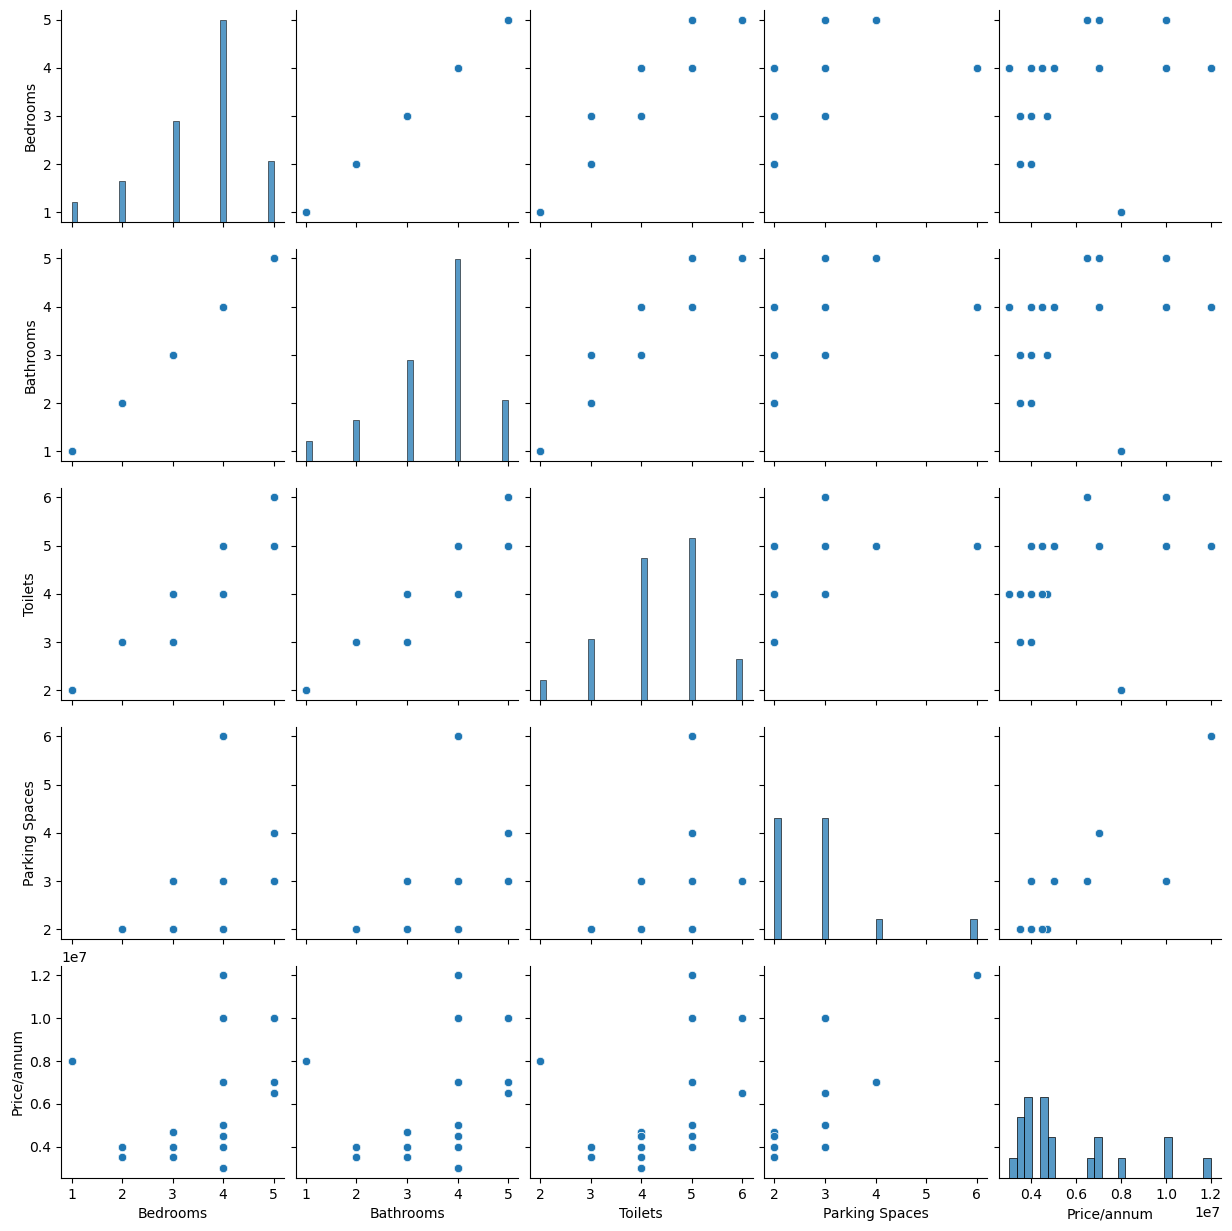

In [2241]:
sns.pairplot(df)
plt.show()

### EDA ON THE NUMERICAL FEATURES

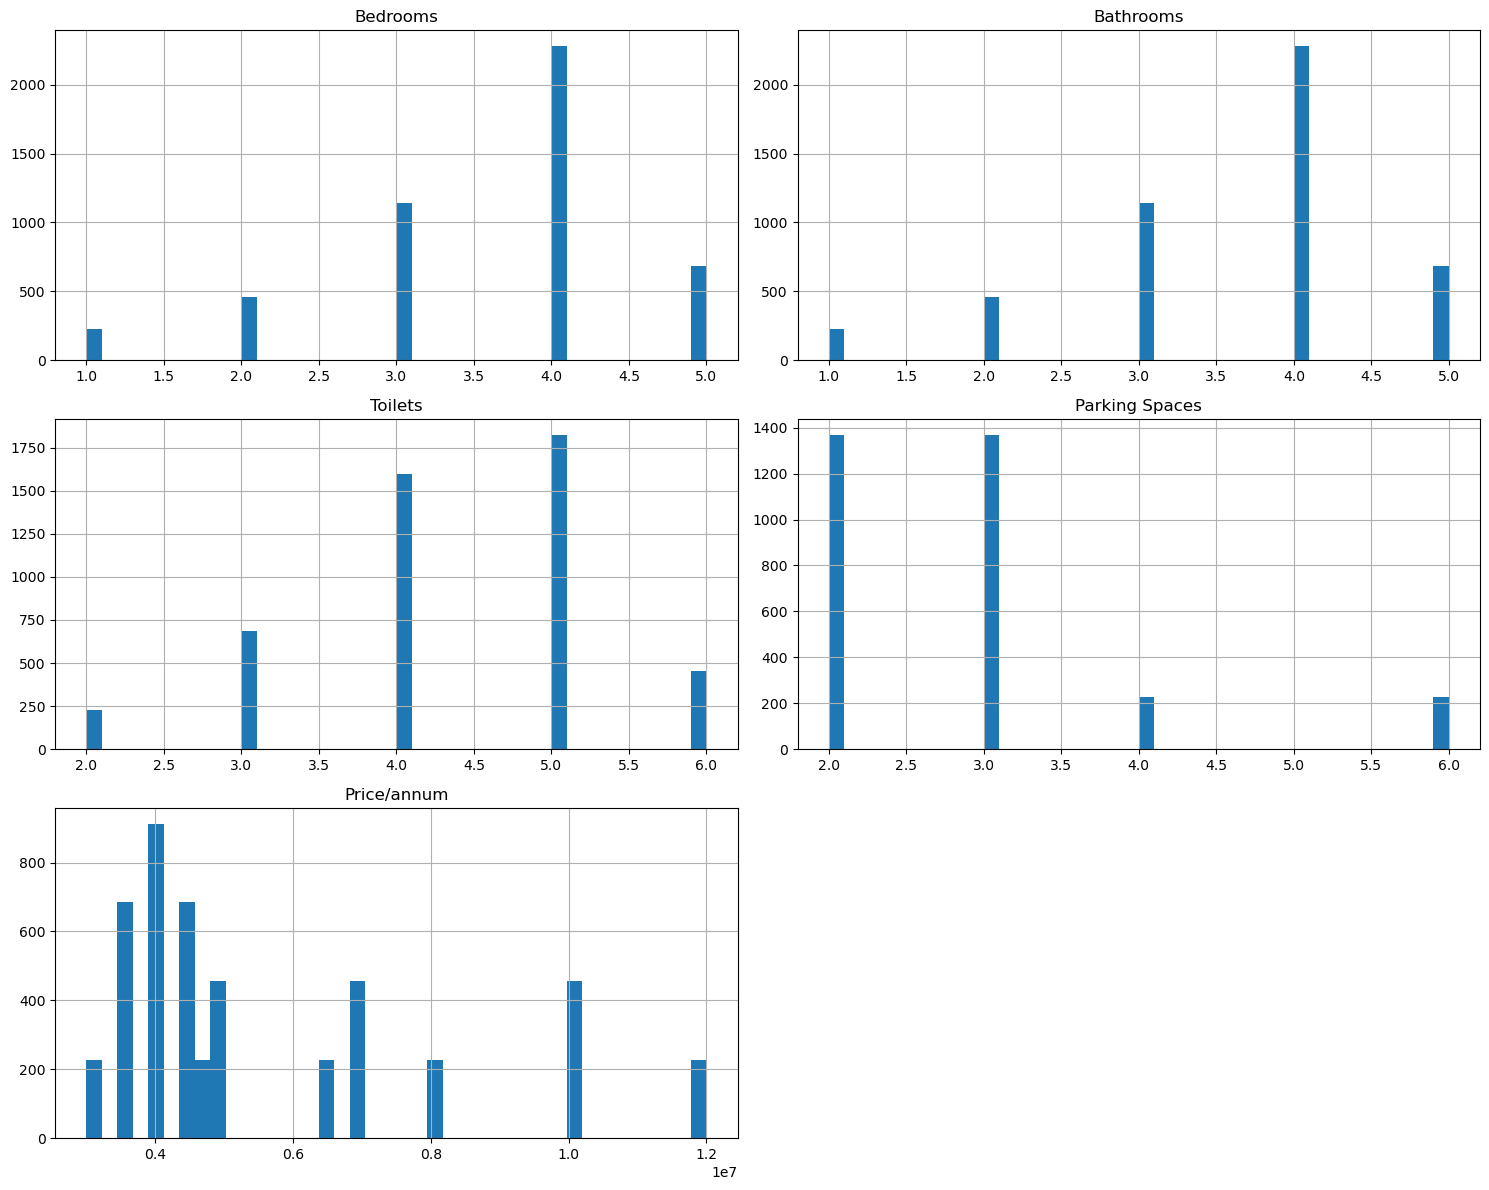

In [2243]:
# Data distribution for numerical columns
df.hist(bins=40, figsize=(15, 12))
plt.tight_layout()
plt.show()

In [2244]:
df.isna().sum()

House_type           0
Bedrooms             0
Bathrooms            0
Toilets              0
Parking Spaces    1596
Location             0
Price/annum          0
dtype: int64

In [2245]:
# Filling the NaN values in 'Parking Spaces' with 0
df['Parking Spaces'] = df['Parking Spaces'].fillna(0)

In [2246]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4788 entries, 0 to 4787
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   House_type      4788 non-null   object 
 1   Bedrooms        4788 non-null   int64  
 2   Bathrooms       4788 non-null   int64  
 3   Toilets         4788 non-null   int64  
 4   Parking Spaces  4788 non-null   float64
 5   Location        4788 non-null   object 
 6   Price/annum     4788 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 262.0+ KB


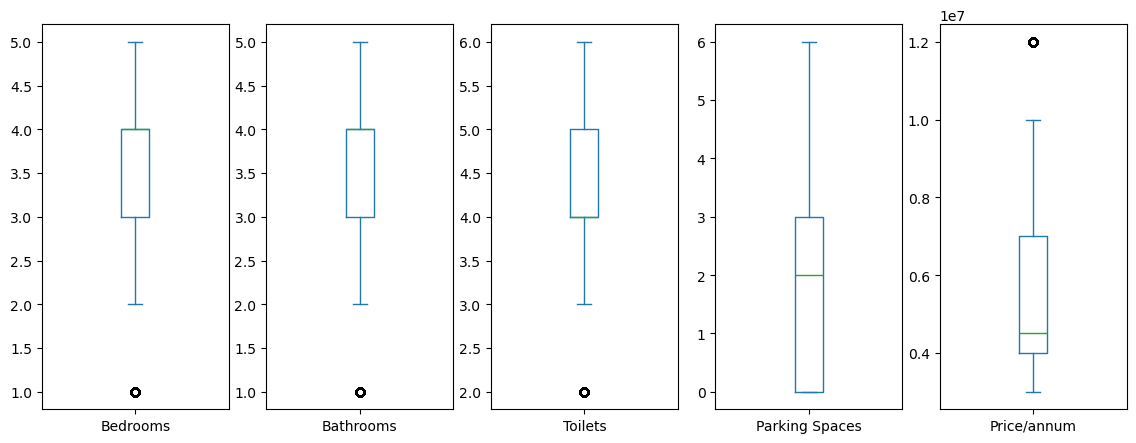

In [2247]:
# Checking for outliers on the numerical columns

numerical_columns = ['Bedrooms', 'Bathrooms', 'Toilets', 'Parking Spaces', 'Price/annum']

df[numerical_columns].plot(
    kind = 'box',
    figsize = (14, 5),
    subplots = True
);

In [2248]:
# Calculate Q1 and Q3 for each numerical column
numerical_columns = ['Bedrooms', 'Bathrooms', 'Toilets', 'Parking Spaces', 'Price/annum']

Q1 = df[numerical_columns].quantile(0.25)
Q3 = df[numerical_columns].quantile(0.75)

# Calculate IQR for each numerical column
IQR = Q3 - Q1

# Determine outlier bounds for each numerical column
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers for each numerical column
outliers = pd.DataFrame()

for column in numerical_columns:
    outlier_mask = (df[column] < lower_bound[column]) | (df[column] > upper_bound[column])
    outliers = pd.concat([outliers, df[column][outlier_mask]], axis=1)
outliers

,Bedrooms,Bathrooms,Toilets,Parking Spaces,Price/annum
7,1.0,1.0,2.0,NaN,NaN
28,1.0,1.0,2.0,NaN,NaN
49,1.0,1.0,2.0,NaN,NaN
70,1.0,1.0,2.0,NaN,NaN
91,1.0,1.0,2.0,NaN,NaN
...,...,...,...,...,...
4693,NaN,NaN,NaN,NaN,12000000.0
4714,NaN,NaN,NaN,NaN,12000000.0
4735,NaN,NaN,NaN,NaN,12000000.0
4756,NaN,NaN,NaN,NaN,12000000.0


In [2249]:
outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456 entries, 7 to 4777
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Bedrooms        228 non-null    float64
 1   Bathrooms       228 non-null    float64
 2   Toilets         228 non-null    float64
 3   Parking Spaces  0 non-null      float64
 4   Price/annum     228 non-null    float64
dtypes: float64(5)
memory usage: 21.4 KB


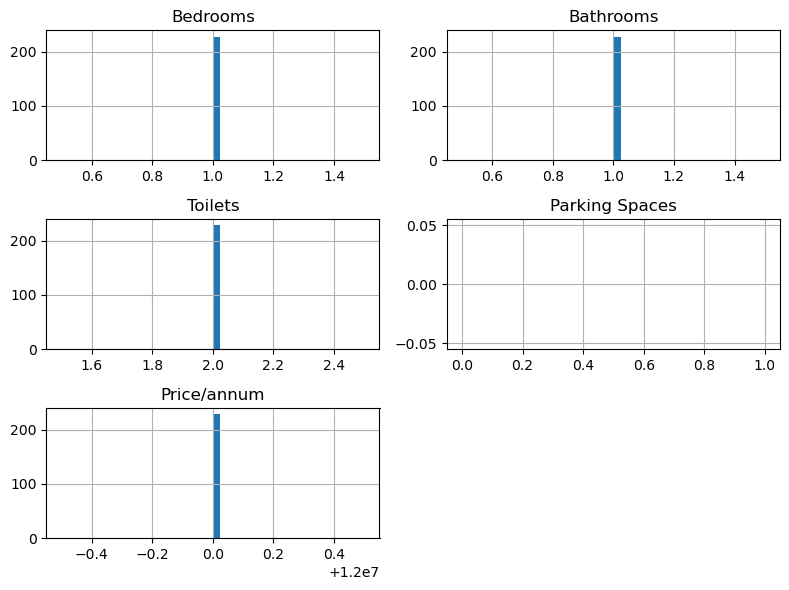

In [2250]:
outlier = outliers.dropna(how='all')

# Data distribution of the outliers
outlier.hist(bins=40, figsize=(8, 6))
plt.tight_layout()
plt.show()

#### Using the Removal Method

In [2252]:
# Filter out rows with outliers
df1 = df.copy()
for column in numerical_columns:
    df1 = df1[(df1[column] >= lower_bound[column]) & (df1[column] <= upper_bound[column])]
df1

,House_type,Bedrooms,Bathrooms,Toilets,Parking Spaces,Location,Price/annum
0,terraced duplex,3,3,4,2.0,Orchid,4700000
1,terraced duplex,3,3,4,2.0,Osapa,4000000
2,detached duplex,5,5,5,4.0,Chevron,7000000
3,terraced duplex,4,4,5,3.0,Ikota,4000000
4,semi-detached duplex,4,4,4,0.0,Lekki,4500000
...,...,...,...,...,...,...,...
4783,house,2,2,3,0.0,Lekki,3500000
4784,house,2,2,3,2.0,Ikate,4000000
4785,semi-detached duplex,4,4,5,0.0,Orchid,7000000
4786,terraced duplex,3,3,3,2.0,Ikota,3500000


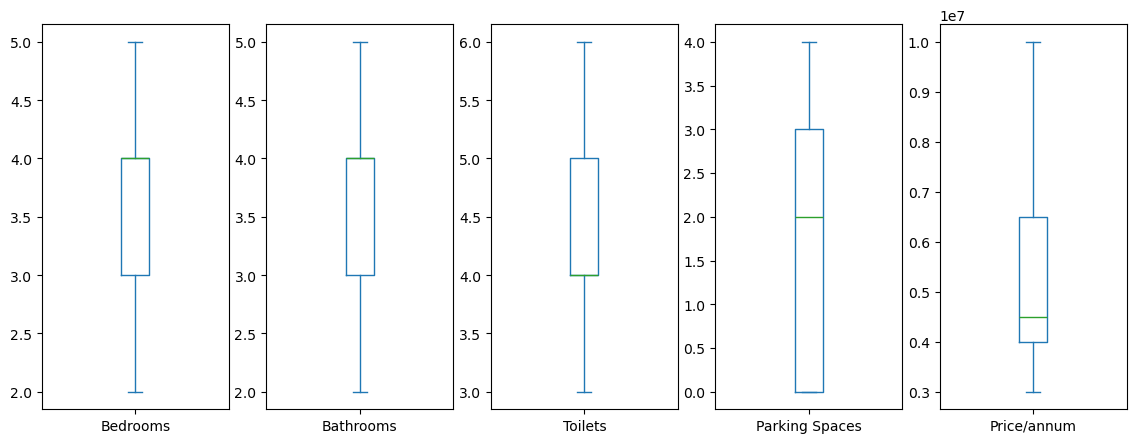

In [2253]:
# Rechecking for outliers on the numerical columns

numerical_columns = ['Bedrooms', 'Bathrooms', 'Toilets', 'Parking Spaces', 'Price/annum']

df1[numerical_columns].plot(
    kind = 'box',
    figsize = (14, 5),
    subplots = True
);

In [2254]:
#observation:

In [2255]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 0 to 4787
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   House_type      4332 non-null   object 
 1   Bedrooms        4332 non-null   int64  
 2   Bathrooms       4332 non-null   int64  
 3   Toilets         4332 non-null   int64  
 4   Parking Spaces  4332 non-null   float64
 5   Location        4332 non-null   object 
 6   Price/annum     4332 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 270.8+ KB


In [2256]:
df.columns

Index(['House_type', 'Bedrooms', 'Bathrooms', 'Toilets', 'Parking Spaces',
       'Location', 'Price/annum'],
      dtype='object')

In [2257]:
cat_features = ['House_type',  'Location']
num_features =['Bedrooms', 'Bathrooms', 'Toilets', 'Parking Spaces']

In [2258]:
# lets explore the correlation between the continous feature variables
# Checking the correlation between the numerical features
correlation = df[num_features].corr()
correlation

,Bedrooms,Bathrooms,Toilets,Parking Spaces
Bedrooms,1.000000,1.000000,0.908943,0.360006
Bathrooms,1.000000,1.000000,0.908943,0.360006
Toilets,0.908943,0.908943,1.000000,0.469799
Parking Spaces,0.360006,0.360006,0.469799,1.000000


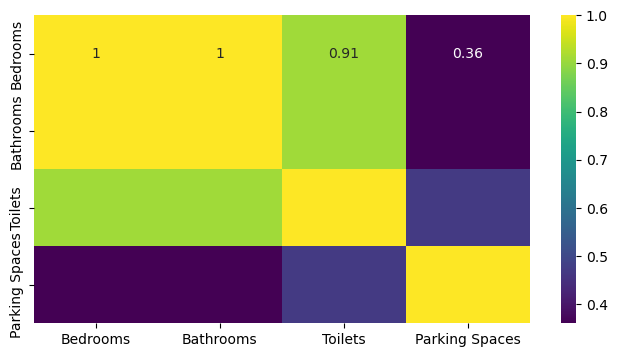

In [2259]:
# visualizing the correlation using a heatmap
plt.figure(figsize=(8,4))
sns.heatmap(correlation,annot = True,cmap= 'viridis')
plt.show()

In [2260]:
# Observation:

<Axes: xlabel='Bedrooms', ylabel='Price/annum'>

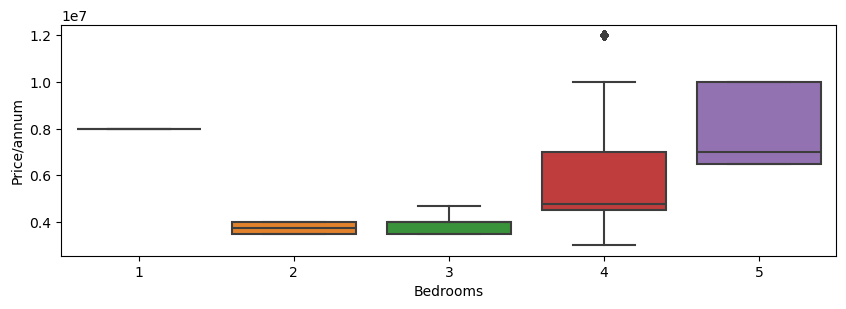

In [2261]:
# Let us explore the relationship between PRICE/annum AND Bedrooms. let see if number of bedrooms determines the rent price of a house
plt.figure(figsize=(10,3))
sns.boxplot(data = df,y='Price/annum',x='Bedrooms')

In [2262]:
# Observation: 

<Axes: xlabel='Bathrooms', ylabel='Price/annum'>

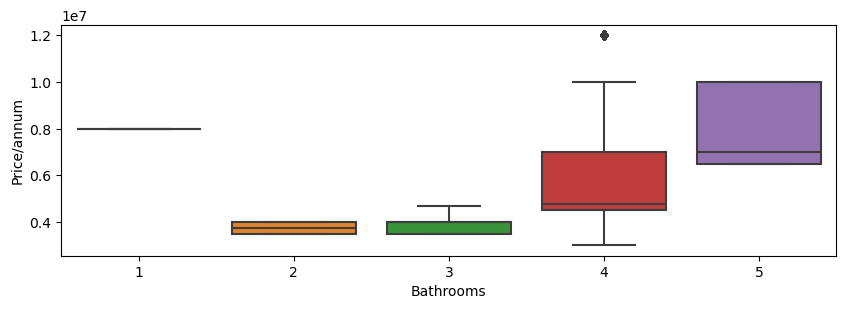

In [2263]:
# Let us explore the relationship between PRICE/annum AND Bathrooms.
plt.figure(figsize=(10,3))
sns.boxplot(data = df,y='Price/annum',x='Bathrooms')

In [2264]:
# Observation:

<Axes: xlabel='Toilets', ylabel='Price/annum'>

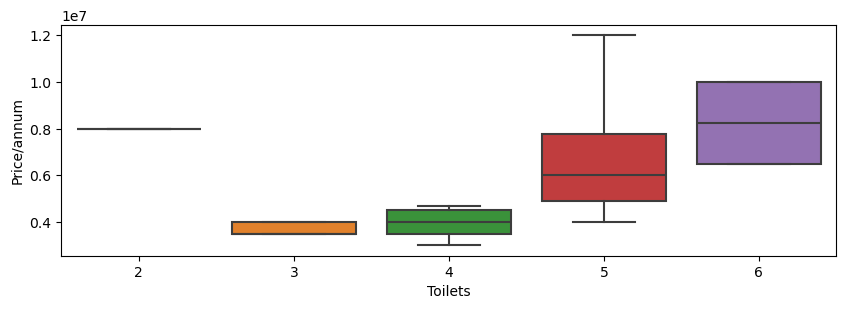

In [2265]:
# Let us explore the relationship between PRICE/annum AND Toilets.
plt.figure(figsize=(10,3))
sns.boxplot(data = df,y='Price/annum',x='Toilets')

In [2266]:
# Observation:

<Axes: xlabel='Parking Spaces', ylabel='Price/annum'>

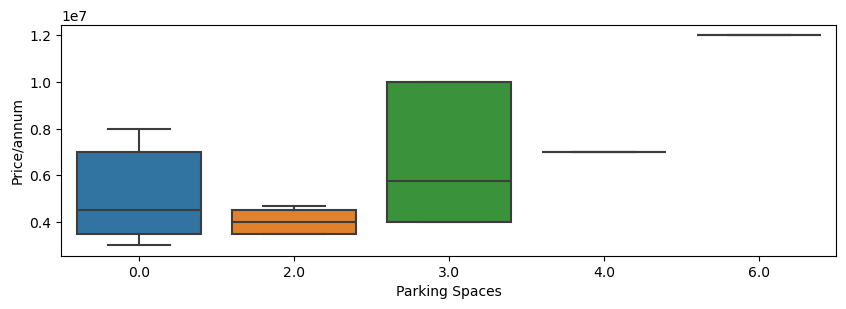

In [2267]:
# Let us explore the relationship between PRICE/annum AND Parking Spaces.
plt.figure(figsize=(10,3))
sns.boxplot(data = df,y='Price/annum',x='Parking Spaces')

In [2268]:
# Observation:

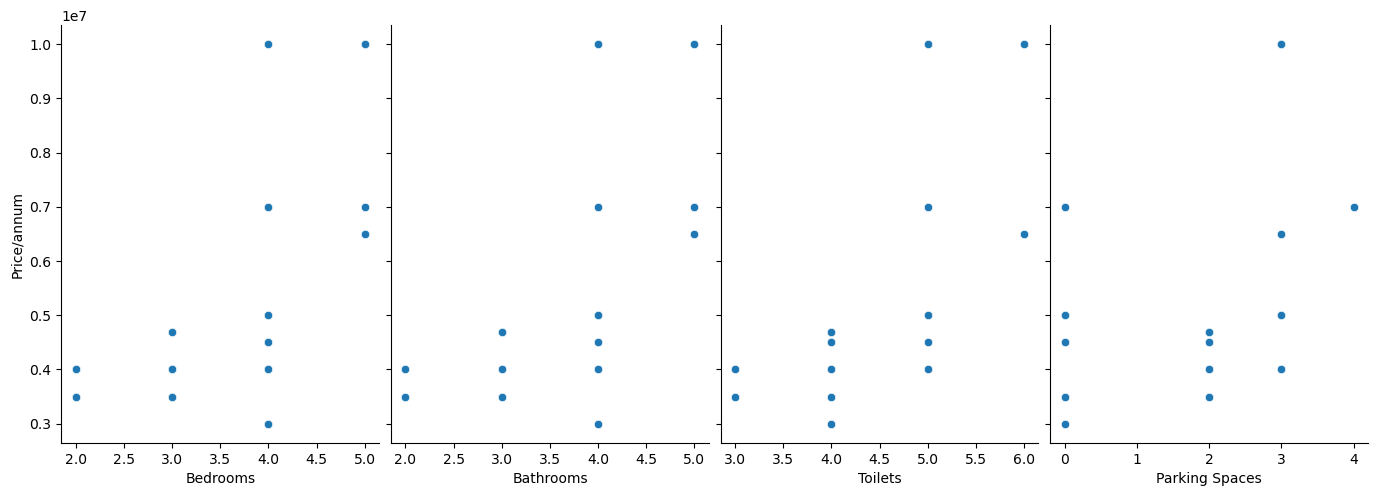

In [2269]:
# Checking the interactions between the numerical features
sns.pairplot(df1, x_vars=['Bedrooms', 'Bathrooms', 'Toilets', 'Parking Spaces'], y_vars='Price/annum', height=5, aspect=0.7)
plt.show()

### EDA ON THE CATEGORICAL FEATURES

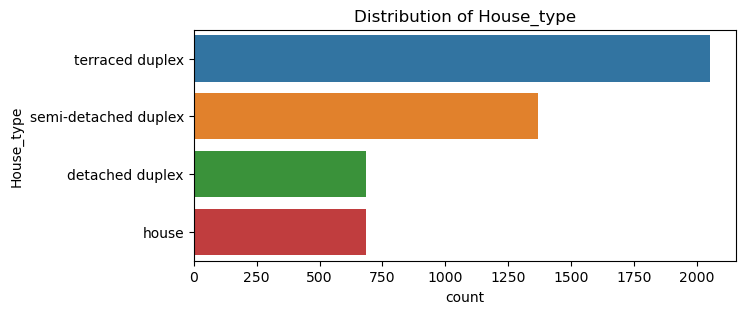

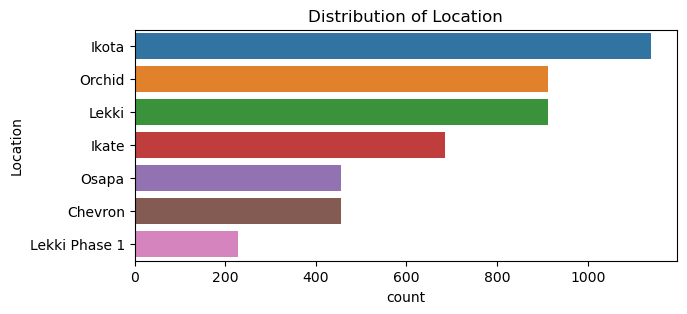

In [2271]:
# Data distribution for categorical columns
categorical_columns = ['House_type', 'Location']

for col in categorical_columns:
    plt.figure(figsize=(7, 3))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.show()

In [2272]:
# Observation:

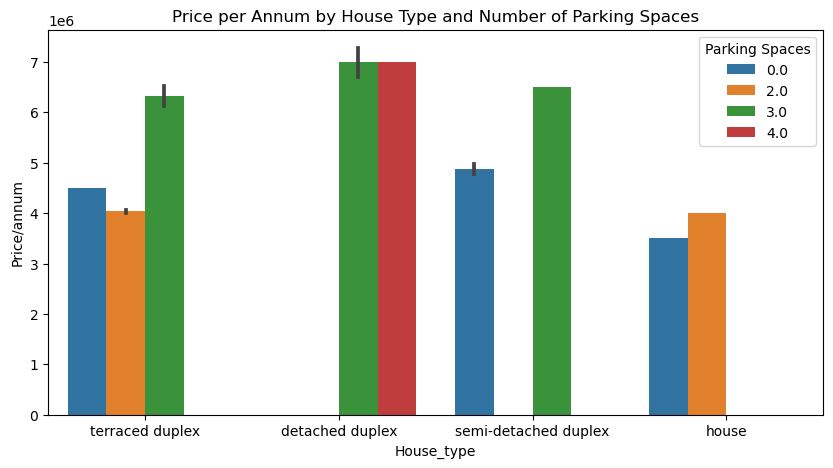

In [2273]:
# House prices per annum for each house type, splited by the number of parking spaces.
plt.figure(figsize=(10, 5))
sns.barplot(x='House_type', y='Price/annum', hue='Parking Spaces', data=df1)
plt.title('Price per Annum by House Type and Number of Parking Spaces')
plt.show()

In [2274]:
# Observation:

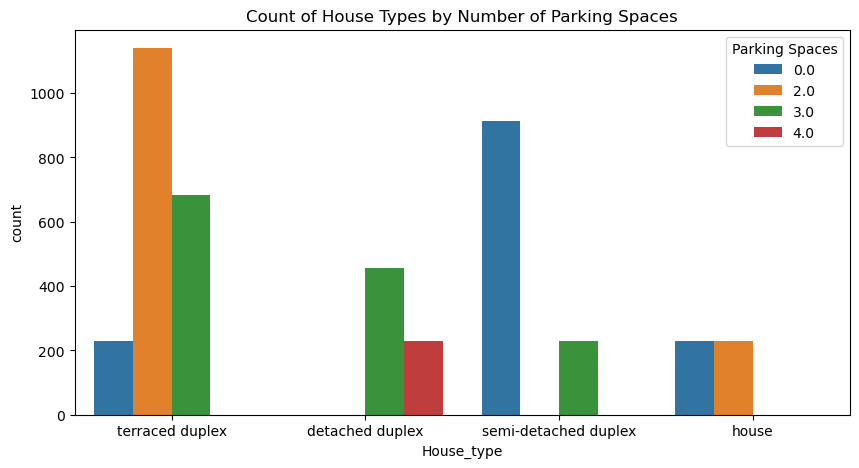

In [2275]:
plt.figure(figsize=(10, 5))
sns.countplot(x='House_type', hue='Parking Spaces', data=df1)
plt.title('Count of House Types by Number of Parking Spaces')
plt.show()

In [2276]:
# Observation:

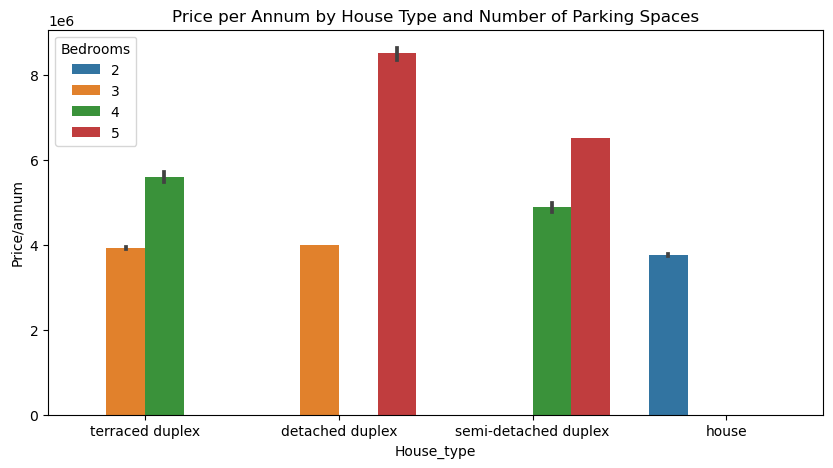

In [2277]:
# House prices per annum for each house type, splited by the number of Bedrooms.
plt.figure(figsize=(10, 5))
sns.barplot(x='House_type', y='Price/annum', hue='Bedrooms', data=df1)
plt.title('Price per Annum by House Type and Number of Parking Spaces')
plt.show()

In [2278]:
# Observation:

#### GROUP ANALYSIS (Calculating the mean price/annus for each subcategory in each categorical features)

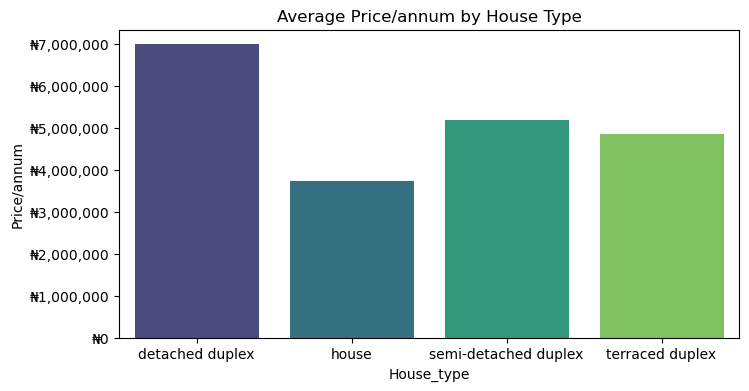

In [2280]:
# Grouping by House_type 
house_type_group = df1.groupby('House_type')['Price/annum'].mean().reset_index()
plt.figure(figsize=(8, 4))
sns.barplot(x='House_type', y='Price/annum', data=house_type_group, palette='viridis')
plt.title('Average Price/annum by House Type')

# formating the y-axis labels
def currency(x, pos):
    'The two args are the value and tick position'
    return '₦{:,.0f}'.format(x)

formatter = FuncFormatter(currency)
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

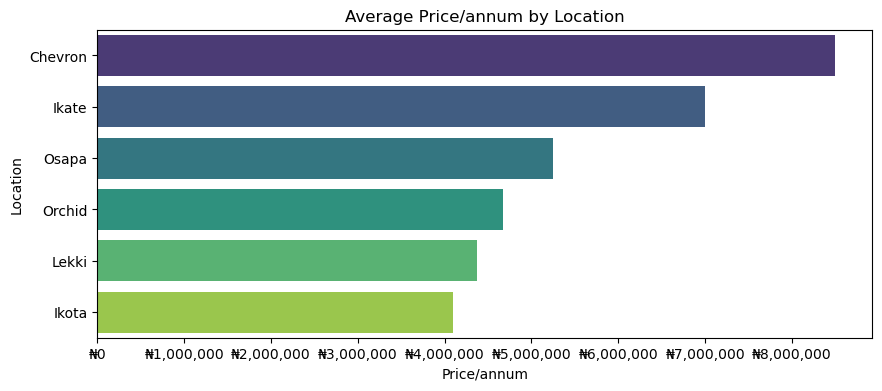

In [2281]:
# Grouping by Location 
location_group = df1.groupby('Location')['Price/annum'].mean().reset_index()

plt.figure(figsize=(10, 4))
sns.barplot(x='Price/annum', y='Location', data=location_group.sort_values(by='Price/annum', ascending=False), palette='viridis')
plt.title('Average Price/annum by Location')
plt.gca().xaxis.set_major_formatter(formatter)

plt.show()

## STEP 5: DATA PREPROCESSING

In [2283]:
# Applying one hot encoding of the categorical variables
df1 = pd.get_dummies(df1, columns=['House_type', 'Location'], drop_first=True)
df1

,Bedrooms,Bathrooms,Toilets,Parking Spaces,Price/annum,House_type_house,House_type_semi-detached duplex,House_type_terraced duplex,Location_Ikate,Location_Ikota,Location_Lekki,Location_Orchid,Location_Osapa
0,3,3,4,2.0,4700000,False,False,True,False,False,False,True,False
1,3,3,4,2.0,4000000,False,False,True,False,False,False,False,True
2,5,5,5,4.0,7000000,False,False,False,False,False,False,False,False
3,4,4,5,3.0,4000000,False,False,True,False,True,False,False,False
4,4,4,4,0.0,4500000,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4783,2,2,3,0.0,3500000,True,False,False,False,False,True,False,False
4784,2,2,3,2.0,4000000,True,False,False,True,False,False,False,False
4785,4,4,5,0.0,7000000,False,True,False,False,False,False,True,False
4786,3,3,3,2.0,3500000,False,False,True,False,True,False,False,False


In [2284]:
X = df1.drop('Price/annum', axis=1)
y = df1['Price/annum']

In [2285]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4332 entries, 0 to 4787
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Bedrooms                         4332 non-null   int64  
 1   Bathrooms                        4332 non-null   int64  
 2   Toilets                          4332 non-null   int64  
 3   Parking Spaces                   4332 non-null   float64
 4   House_type_house                 4332 non-null   bool   
 5   House_type_semi-detached duplex  4332 non-null   bool   
 6   House_type_terraced duplex       4332 non-null   bool   
 7   Location_Ikate                   4332 non-null   bool   
 8   Location_Ikota                   4332 non-null   bool   
 9   Location_Lekki                   4332 non-null   bool   
 10  Location_Orchid                  4332 non-null   bool   
 11  Location_Osapa                   4332 non-null   bool   
dtypes: bool(8), float64(1), i

#### Checking for multicollinearity among features by VIF

In [2287]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Convert boolean columns to integers
bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype(int)

# Calculating the VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,Bedrooms,inf
1,Bathrooms,inf
2,Toilets,155.814819
3,Parking Spaces,12.520599
4,House_type_house,5.307448
5,House_type_semi-detached duplex,14.719869
6,House_type_terraced duplex,16.263552
7,Location_Ikate,5.927681
8,Location_Ikota,10.653705
9,Location_Lekki,7.868326


In [2288]:
# Observation:

In [2289]:
X['Rooms'] = df['Bedrooms'] * df['Bathrooms']
X

,Bedrooms,Bathrooms,Toilets,Parking Spaces,House_type_house,House_type_semi-detached duplex,House_type_terraced duplex,Location_Ikate,Location_Ikota,Location_Lekki,Location_Orchid,Location_Osapa,Rooms
0,3,3,4,2.0,0,0,1,0,0,0,1,0,9
1,3,3,4,2.0,0,0,1,0,0,0,0,1,9
2,5,5,5,4.0,0,0,0,0,0,0,0,0,25
3,4,4,5,3.0,0,0,1,0,1,0,0,0,16
4,4,4,4,0.0,0,1,0,0,0,1,0,0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4783,2,2,3,0.0,1,0,0,0,0,1,0,0,4
4784,2,2,3,2.0,1,0,0,1,0,0,0,0,4
4785,4,4,5,0.0,0,1,0,0,0,0,1,0,16
4786,3,3,3,2.0,0,0,1,0,1,0,0,0,9


In [2290]:
# Observation: 

#### CHECKING FEATURE IMPORTANCE FOR ALL THE CATEGORY OF FEATURES USING MUTUAL INFORMATION REGRESSION

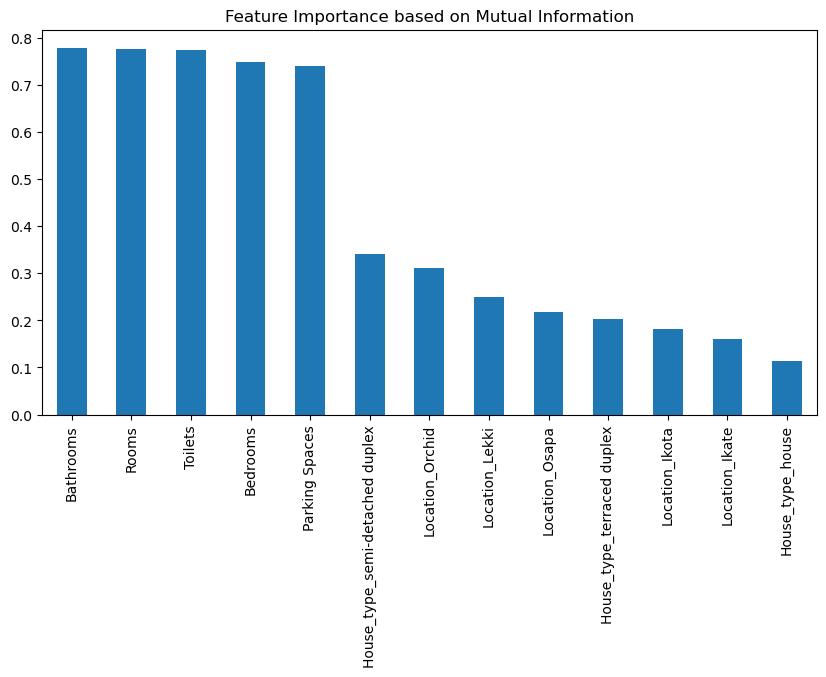

In [2292]:
# Compute mutual information
mi = mutual_info_regression(X, y)
mi = pd.Series(mi, index=X.columns)
mi.sort_values(ascending=False).plot.bar(figsize=(10, 5))
plt.title('Feature Importance based on Mutual Information')
plt.show()

In [2293]:
mi

Bedrooms                           0.748638
Bathrooms                          0.778226
Toilets                            0.773747
Parking Spaces                     0.740519
House_type_house                   0.114318
House_type_semi-detached duplex    0.341666
House_type_terraced duplex         0.203659
Location_Ikate                     0.160810
Location_Ikota                     0.181477
Location_Lekki                     0.249765
Location_Orchid                    0.310441
Location_Osapa                     0.216992
Rooms                              0.776442
dtype: float64

In [2294]:
# Observation:

In [2295]:
# Splitting the data into training, validation and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_hold_test, y_val, y_hold_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


print(X_hold_test.shape)
print(X_val.shape)
print(X_train.shape)

(434, 13)
(433, 13)
(3465, 13)


In [2296]:
# Observation

In [2297]:
X_train

,Bedrooms,Bathrooms,Toilets,Parking Spaces,House_type_house,House_type_semi-detached duplex,House_type_terraced duplex,Location_Ikate,Location_Ikota,Location_Lekki,Location_Orchid,Location_Osapa,Rooms
1302,3,3,4,2.0,0,0,1,0,0,0,1,0,9
969,4,4,5,3.0,0,0,1,0,1,0,0,0,16
4680,4,4,5,0.0,0,1,0,0,0,0,1,0,16
4571,4,4,5,0.0,0,1,0,0,1,0,0,0,16
3977,3,3,4,3.0,0,0,0,0,0,0,1,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3806,4,4,4,0.0,0,0,1,0,0,1,0,0,16
516,4,4,5,3.0,0,0,1,1,0,0,0,0,16
3418,2,2,3,0.0,1,0,0,0,0,1,0,0,4
4170,4,4,5,3.0,0,0,1,1,0,0,0,0,16


## STEP 6: MODEL TRAINING

#### USING LINEAR REGRESSION

In [2300]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

In [2301]:
lr = LinearRegression()

In [2302]:
lr.fit(X_train, y_train)

LinearRegression()

In [2303]:
y_pred_train = lr.predict(X_train)
y_pred_val = lr.predict(X_val)

In [2304]:
# Calculate training and testing errors
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_val, y_pred_val)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_val, y_pred_val)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_val, y_pred_val)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
mape_test = mean_absolute_percentage_error(y_val, y_pred_val)

print(f"Training MAPE: {mape_train:.2f}")
print(f"Testing MAPE: {mape_test:.2f}")
print(f"Training MAE: {mae_train:.2f}")
print(f"Testing MAE: {mae_test:.2f}")
print(f"Training MSE: {mse_train:.2f}")
print(f"Testing MSE: {mse_test:.2f}")
print(f"Training R²: {r2_train:.2f}")
print(f"Testing R²: {r2_test:.2f}")

Training MAPE: 0.11
Testing MAPE: 0.11
Training MAE: 456085.15
Testing MAE: 463235.25
Training MSE: 397558423823.83
Testing MSE: 401652665763.44
Training R²: 0.90
Testing R²: 0.91


In [2305]:
# Combine actual and predicted values into a single DataFrame
lr_combined_data = pd.DataFrame({
    'Actual': y_val,
    'Predicted': y_pred_val
})
lr_combined_data.head()

,Actual,Predicted
528,4000000,3.916148e+06
93,6500000,6.500000e+06
2012,4000000,4.976754e+06
886,4500000,4.502310e+06
1665,3000000,3.687237e+06


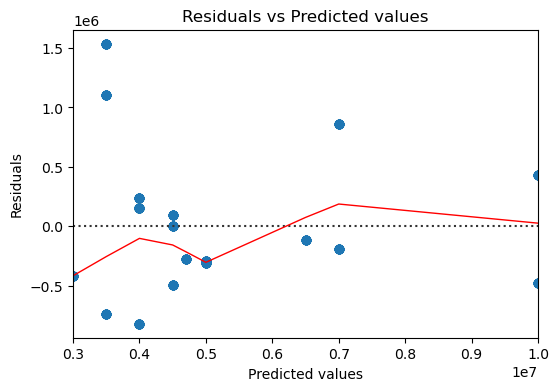

In [2306]:
# Calculate residuals
residuals = y_val - y_pred_val

# Plot residuals
plt.figure(figsize=(6, 4))
sns.residplot(x=y_val, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values')
plt.show()


#### USING RIDGE REGRESSION

In [2308]:
from sklearn.linear_model import Ridge

In [2309]:
ridge = Ridge(alpha=0.1)

In [2310]:
ridge.fit(X_train, y_train)

Ridge(alpha=0.1)

In [2311]:
ridge_train_pred = ridge.predict(X_train)
ridge_val_pred = ridge.predict(X_val)

In [2312]:
ridge_train_mape = np.mean(np.abs((y_train - ridge_train_pred) / y_train))
ridge_test_mape = np.mean(np.abs((y_val - ridge_val_pred) / y_val))
ridge_train_mae = mean_absolute_error(y_train, ridge_train_pred)
ridge_test_mae = mean_absolute_error(y_val, ridge_val_pred)
ridge_train_mse = mean_squared_error(y_train, ridge_train_pred)
ridge_test_mse = mean_squared_error(y_val, ridge_val_pred)
ridge_train_r2 = r2_score(y_train, ridge_train_pred)
ridge_test_r2 = r2_score(y_val, ridge_val_pred)

print(f"Ridge Regression Training MAPE: {ridge_train_mape:.2f}")
print(f"Ridge Regression Testing MAPE: {ridge_test_mape:.2f}")
print(f"Ridge Regression Training MAE: {ridge_train_mae:.2f}")
print(f"Ridge Regression Testing MAE: {ridge_test_mae:.2f}")
print(f"Ridge Regression Training MSE: {ridge_train_mse:.2f}")
print(f"Ridge Regression Testing MSE: {ridge_test_mse:.2f}")
print(f"Ridge Regression Training R²: {ridge_train_r2:.2f}")
print(f"Ridge Regression Testing R²: {ridge_test_r2:.2f}")


Ridge Regression Training MAPE: 0.11
Ridge Regression Testing MAPE: 0.11
Ridge Regression Training MAE: 457662.54
Ridge Regression Testing MAE: 465302.52
Ridge Regression Training MSE: 397681341656.14
Ridge Regression Testing MSE: 402506901405.91
Ridge Regression Training R²: 0.90
Ridge Regression Testing R²: 0.91


In [2313]:
# Combine actual and predicted values into a single DataFrame
rg_combined_data = pd.DataFrame({
    'Actual': y_val,
    'Predicted': ridge_val_pred
})
rg_combined_data

,Actual,Predicted
528,4000000,3.936650e+06
93,6500000,6.486581e+06
2012,4000000,4.980805e+06
886,4500000,4.500583e+06
1665,3000000,3.701529e+06
...,...,...
2315,4500000,5.089008e+06
3974,4500000,5.089008e+06
2560,3500000,2.163091e+06
2693,4500000,5.089008e+06


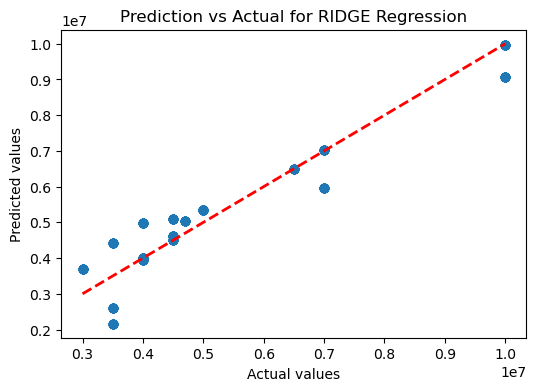

In [2314]:
plt.figure(figsize=(6, 4))
plt.scatter(y_val, ridge_val_pred, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Prediction vs Actual for RIDGE Regression')
plt.show()

### USING LASSO REGRESSION

In [2316]:
from sklearn.linear_model import Lasso

In [2317]:
lasso = Lasso(alpha=1.0)

In [2318]:
lasso.fit(X_train, y_train)

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.315e+14, tolerance: 1.356e+12
  model = cd_fast.enet_coordinate_descent(


Lasso()

In [2319]:
lasso_train_pred = lasso.predict(X_train)
lasso_val_pred = lasso.predict(X_val)

In [2320]:
lasso_train_mape = np.mean(np.abs((y_train - lasso_train_pred) / y_train))
lasso_test_mape = np.mean(np.abs((y_val - lasso_val_pred) / y_val))
lasso_train_mae = mean_absolute_error(y_train, lasso_train_pred)
lasso_test_mae = mean_absolute_error(y_val, lasso_val_pred)
lasso_train_mse = mean_squared_error(y_train,lasso_train_pred)
lasso_test_mse = mean_squared_error(y_val, lasso_val_pred)
lasso_train_r2 = r2_score(y_train, lasso_train_pred)
lasso_test_r2 = r2_score(y_val, lasso_val_pred)

print(f"Lasso Regression Training MAPE: {lasso_train_mape:.2f}")
print(f"Lasso Regression Testing MAPE: {lasso_test_mape:.2f}")
print(f"Lasso Regression Training MAE: {lasso_train_mae:.2f}")
print(f"Lasso Regression Testing MAE: {lasso_test_mae:.2f}")
print(f"Lasso Regression Training MSE: {lasso_train_mse:.2f}")
print(f"Lasso Regression Testing MSE: {lasso_test_mse:.2f}")
print(f"Lasso Regression Training R²: {lasso_train_r2:.2f}")
print(f"Lasso Regression Testing R²: {lasso_test_r2:.2f}")


Lasso Regression Training MAPE: 0.12
Lasso Regression Testing MAPE: 0.12
Lasso Regression Training MAE: 506460.55
Lasso Regression Testing MAE: 514109.74
Lasso Regression Training MSE: 422380883521.52
Lasso Regression Testing MSE: 431331980596.47
Lasso Regression Training R²: 0.89
Lasso Regression Testing R²: 0.90


In [2321]:
# Combine actual and predicted values into a single DataFrame
combined_data = pd.DataFrame({
    'Actual': y_val,
    'Predicted': lasso_val_pred
})
combined_data

,Actual,Predicted
528,4000000,4.154877e+06
93,6500000,6.219127e+06
2012,4000000,5.009659e+06
886,4500000,4.550186e+06
1665,3000000,3.840433e+06
...,...,...
2315,4500000,4.929423e+06
3974,4500000,4.929423e+06
2560,3500000,2.022236e+06
2693,4500000,4.929423e+06


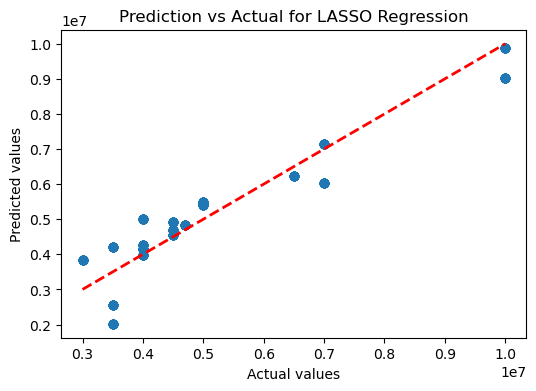

In [2322]:
plt.figure(figsize=(6, 4))
plt.scatter(y_val, lasso_val_pred, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Prediction vs Actual for LASSO Regression')
plt.show()

#### USING POLYNOMIAL FEATURES

In [2324]:
from sklearn.preprocessing import PolynomialFeatures
# Creating polynomial features
poly = PolynomialFeatures(degree=1, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_hold_test)

In [2325]:
# Fitting the linear regression model
plr = LinearRegression()
plr.fit(X_train_poly, y_train)

LinearRegression()

In [2326]:
# Making predictions
plr_train = plr.predict(X_train_poly)
plr_val = plr.predict(X_val_poly)

In [2327]:
from sklearn.metrics import root_mean_squared_error

In [2328]:
plr_train_mape = np.mean(np.abs((y_train - plr_train) / y_train))
plr_test_mape = np.mean(np.abs((y_val - plr_val) / y_val))
plr_train_mae = mean_absolute_error(y_train, plr_train)
plr_test_mae = mean_absolute_error(y_val, plr_val)
plr_train_mse = mean_squared_error(y_train, plr_train)
plr_test_mse = mean_squared_error(y_val, plr_val)
plr_train_r2 = r2_score(y_train, plr_train)
plr_test_r2 = r2_score(y_val, plr_val)
plr_train_rmse = root_mean_squared_error(y_train, plr_train)
plr_test_rmse = root_mean_squared_error(y_val, plr_val)

# Print the evaluation metrics
print(f'Training RMSE: {plr_train_rmse:.2f}')
print(f'Training RMSE: {plr_test_rmse:.2f}')
print(f'Training MAPE: {plr_train_mape:.2f}')
print(f'Testing MAPE: {plr_test_mape:.2f}')
print(f'Training MAE: {plr_train_mae:.2f}')
print(f'Testing MAE: {plr_test_mae:.2f}')
print(f'Training MSE: {plr_train_mse:.2f}')
print(f'Testing MSE: {plr_test_mse:.2f}')
print(f'Training R²: {plr_train_r2:.2f}')
print(f'Testing R²: {plr_test_r2:.2f}')

Training RMSE: 630522.34
Training RMSE: 633760.73
Training MAPE: 0.11
Testing MAPE: 0.11
Training MAE: 456085.15
Testing MAE: 463235.25
Training MSE: 397558423823.83
Testing MSE: 401652665763.44
Training R²: 0.90
Testing R²: 0.91


In [2329]:
# Combine actual and predicted values into a single DataFrame
plr_combined_data = pd.DataFrame({
    'Actual': y_val,
    'Predicted': plr_val
})
plr_combined_data

,Actual,Predicted
528,4000000,3.916148e+06
93,6500000,6.500000e+06
2012,4000000,4.976754e+06
886,4500000,4.502310e+06
1665,3000000,3.687237e+06
...,...,...
2315,4500000,5.095574e+06
3974,4500000,5.095574e+06
2560,3500000,2.172127e+06
2693,4500000,5.095574e+06


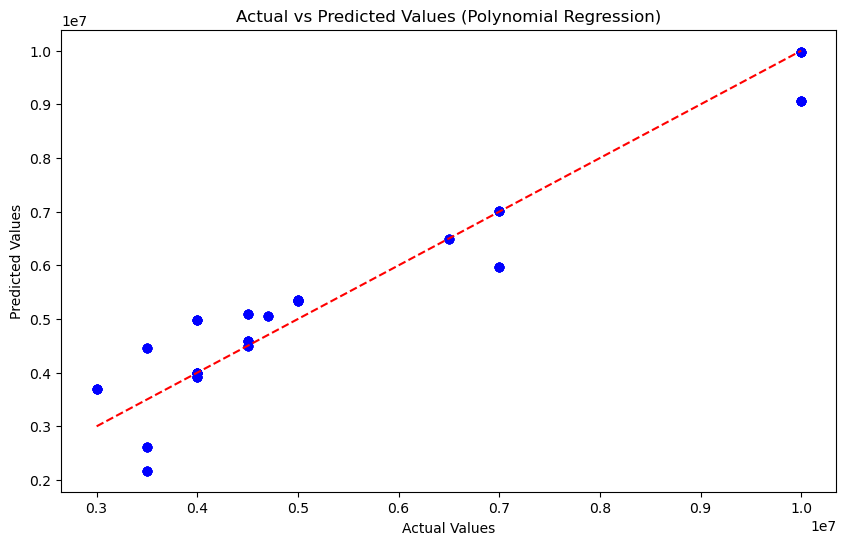

In [2330]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val, plr_val, alpha=0.3, color='blue')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Polynomial Regression)')
plt.show()

In [2331]:
from sklearn.ensemble import RandomForestRegressor

In [2332]:
rf = RandomForestRegressor(bootstrap = True, max_depth = None, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 100, random_state=42)

In [2333]:
# Train the model
rf.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', random_state=42)

In [2334]:
# Making predictions
rf_train = rf.predict(X_train)
rf_val = rf.predict(X_val)

In [2335]:
rf_train_mape = np.mean(np.abs((y_train - rf_train) / y_train))
rf_test_mape = np.mean(np.abs((y_val - rf_val) / y_val))
rf_train_mae = mean_absolute_error(y_train, rf_train)
rf_test_mae = mean_absolute_error(y_val, rf_val)
rf_train_mse = mean_squared_error(y_train, rf_train)
rf_test_mse = mean_squared_error(y_val, rf_val)
rf_train_r2 = r2_score(y_train, rf_train)
rf_test_r2 = r2_score(y_val, rf_val)
rf_train_rmse = root_mean_squared_error(y_train, rf_train)
rf_test_rmse = root_mean_squared_error(y_val, rf_val)

# Print the evaluation metrics
print(f'Training RMSE: {rf_train_rmse:.2f}')
print(f'Training RMSE: {rf_test_rmse:.2f}')
print(f'Training MAPE: {rf_train_mape:.2f}')
print(f'Testing MAPE: {rf_test_mape:.2f}')
print(f'Training MAE: {rf_train_mae:.2f}')
print(f'Testing MAE: {rf_test_mae:.2f}')
print(f'Training MSE: {rf_train_mse:.2f}')
print(f'Testing MSE: {rf_test_mse:.2f}')
print(f'Training R²: {rf_train_r2:.2f}')
print(f'Testing R²: {rf_test_r2:.2f}')

Training RMSE: 0.00
Training RMSE: 0.00
Training MAPE: 0.00
Testing MAPE: 0.00
Training MAE: 0.00
Testing MAE: 0.00
Training MSE: 0.00
Testing MSE: 0.00
Training R²: 1.00
Testing R²: 1.00


In [2337]:
# Combining all actual and all model predicted values into a single DataFrame
all_combined_data = pd.DataFrame({
    'Actual': y_val,
    'Predicted by lr': y_pred_val,
    'Predicted by Ridge': ridge_val_pred,
    'Predicted by lasso': lasso_val_pred,
    'Predicted by polynomial_r': plr_val,
    'Predicted by randomforest regressor': rf_val,
})
all_combined_data

,Actual,Predicted by lr,Predicted by Ridge,Predicted by lasso,Predicted by polynomial_r,Predicted by randomforest regressor
528,4000000,3.916148e+06,3.936650e+06,4.154877e+06,3.916148e+06,4000000.0
93,6500000,6.500000e+06,6.486581e+06,6.219127e+06,6.500000e+06,6500000.0
2012,4000000,4.976754e+06,4.980805e+06,5.009659e+06,4.976754e+06,4000000.0
886,4500000,4.502310e+06,4.500583e+06,4.550186e+06,4.502310e+06,4500000.0
1665,3000000,3.687237e+06,3.701529e+06,3.840433e+06,3.687237e+06,3000000.0
...,...,...,...,...,...,...
2315,4500000,5.095574e+06,5.089008e+06,4.929423e+06,5.095574e+06,4500000.0
3974,4500000,5.095574e+06,5.089008e+06,4.929423e+06,5.095574e+06,4500000.0
2560,3500000,2.172127e+06,2.163091e+06,2.022236e+06,2.172127e+06,3500000.0
2693,4500000,5.095574e+06,5.089008e+06,4.929423e+06,5.095574e+06,4500000.0


In [2450]:
df['Price/annum'].mean()

5628571.428571428

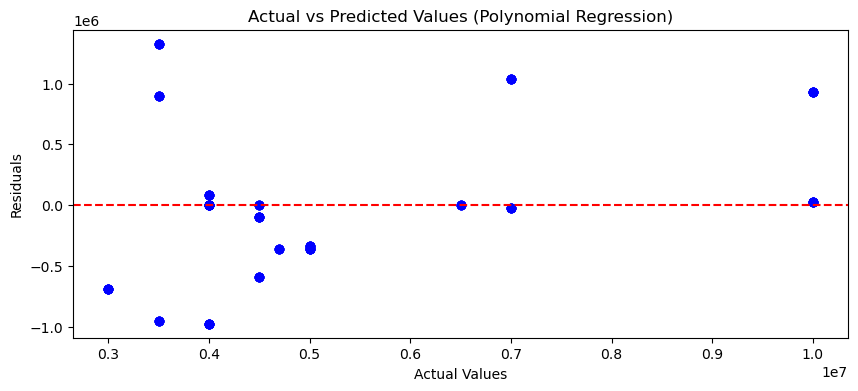

In [2338]:
residuals = y_val - plr_val

plt.figure(figsize=(10, 4))
plt.scatter(y_val, residuals, alpha=0.3, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Actual vs Predicted Values (Polynomial Regression)')
plt.show()

In [ ]:
models = [lr, ridge, lasso, plr, rf]
results_list = []

for model in models:
    y_pred = model.predict(X_hold_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results_list.append({
        'Model': model,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

results_df = pd.DataFrame(results_list)
results_df